In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchaudio
import torchvision
import torchmetrics 
from torchsummary import summary

import librosa
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from IPython import display

device = torch.device("cuda")

E:\Users\Kosar 37638090\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
E:\Users\Kosar 37638090\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
train_dir = "./train"
test_dir = "./test"
train_voices = glob.glob(train_dir + "/*/*.wav")
valid_voices = glob.glob(test_dir + "/*/*.wav")

In [3]:
class VoiceRecognaitionDataset(Dataset):
    def __init__(self, voices):
        super(VoiceRecognaitionDataset, self).__init__()
        self.voices = voices
        self.classes = os.listdir("./train")
        self.spectogram = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=32)
        self.ampitude = torchaudio.transforms.AmplitudeToDB()
        self.resizer = torchvision.transforms.Resize((128, 128))
    
    
    def __getitem__(self, index):
        voice, _ = torchaudio.load(self.voices[index])
        voice = self.spectogram(voice)
        # voice = self.ampitude(voice)
        voice = librosa.power_to_db(voice)
        voice = torch.tensor(voice)
        voice = self.resizer(voice)
        voice = (voice + 125) / 200
        

        label = self.voices[index].split("\\")[-2]
        one_hot_label = np.zeros((len(self.classes))).tolist()
        one_hot_idx = self.classes.index(label)
        # one_hot_label[one_hot_idx] = 1
        # one_hot_label = torch.tensor(one_hot_label).long()
        return voice, one_hot_idx

    def __len__(self):
        return len(self.voices)


In [4]:
train_ds = VoiceRecognaitionDataset(voices=train_voices)
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True, num_workers=8)

In [5]:
valid_ds = VoiceRecognaitionDataset(voices=valid_voices)
valid_dl = DataLoader(valid_ds, batch_size=1024, shuffle=True, num_workers=8)

In [6]:
train_ds[30000][1]

E:\Users\Kosar 37638090\anaconda3\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
E:\Users\Kosar 37638090\anaconda3\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


14

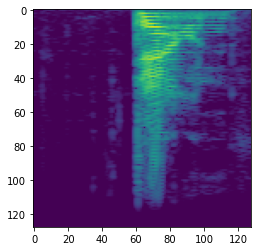

In [7]:
plt.imshow(train_ds[0][0][0])

In [8]:
class VoiceRecognaitionModel(nn.Module):
    def res_block (self, input_kernel, output_kernel, kernel_size=3, pad_num=1):
        block = nn.Sequential(
            nn.Conv2d(in_channels=input_kernel, out_channels=output_kernel, kernel_size=1),
            nn.BatchNorm2d(num_features=output_kernel),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=output_kernel, out_channels=output_kernel, kernel_size=kernel_size, padding=pad_num),
            nn.BatchNorm2d(num_features=output_kernel),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=output_kernel, out_channels=output_kernel, kernel_size=1),
            nn.BatchNorm2d(num_features=output_kernel),
            nn.LeakyReLU()
        )
        return block
    def pooling_block(self, input_kernel, output_kernel, kernel_size=3, pad_num=1):
        block = nn.Sequential(
            nn.Conv2d(in_channels=input_kernel, out_channels=output_kernel, kernel_size=kernel_size, padding=pad_num, stride=2),
            nn.BatchNorm2d(num_features=output_kernel),
            nn.LeakyReLU(),
        )
        return block
    def fully_connecteds(self, conv_output, num_classes):
        block = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features=conv_output, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        return block
    
    def __init__(self):
        super(VoiceRecognaitionModel, self).__init__()
        self.num_classes = 21

        self.res_block_1 = self.res_block(2, 2, 7, 3)
        self.res_block_2 = self.res_block(4, 4)
        self.res_block_3 = self.res_block(8, 8)
        self.res_block_4 = self.res_block(16, 16)
        self.res_block_5 = self.res_block(32, 32)
        self.res_block_6 = self.res_block(64, 64)

        self.pooling_block_1 = self.pooling_block(1, 2) # 128
        self.pooling_block_2 = self.pooling_block(2, 4) # 64
        self.pooling_block_3 = self.pooling_block(4, 8) # 32
        self.pooling_block_4 = self.pooling_block(8, 16) # 16
        self.pooling_block_5 = self.pooling_block(16, 32) # 8
        self.pooling_block_6 = self.pooling_block(32, 64) # 4
        self.pooling_block_7 = self.pooling_block(64, 128) # 2

        self.fc_block = self.fully_connecteds(1*1*128, self.num_classes)

    def forward(self,  inputs):
        block_1 = self.pooling_block_1(inputs)
        block_2 = self.res_block_1(block_1)
        block_2 =  torch.add(block_1, block_2)

        block_3 = self.pooling_block_2(block_2)
        block_4 = self.res_block_2(block_3)
        block_4 = torch.add(block_3, block_4)

        block_5 = self.pooling_block_3(block_4)
        block_6 = self.res_block_3(block_5)
        block_6 = torch.add(block_5, block_6)

        block_7 = self.pooling_block_4(block_6)
        block_8 = self.res_block_4(block_7)
        block_8 = torch.add(block_7, block_8)

        block_9 = self.pooling_block_5(block_8)
        block_10 = self.res_block_5(block_9)
        block_10 = torch.add(block_9, block_10)


        block_11 = self.pooling_block_6(block_10)
        block_12 = self.res_block_6(block_11)
        block_12 = torch.add(block_11, block_12)

        block_13 = self.pooling_block_7(block_12)
        block_13 = block_13.view(block_13.size(0), -1)

        block_fc = self.fc_block(block_13)
        return block_fc


In [9]:
model = VoiceRecognaitionModel()
model = model.to(device=device)

In [10]:
summary(model, (1, 128, 128), batch_size=2048)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2048, 2, 64, 64]              20
       BatchNorm2d-2          [2048, 2, 64, 64]               4
         LeakyReLU-3          [2048, 2, 64, 64]               0
            Conv2d-4          [2048, 2, 64, 64]               6
       BatchNorm2d-5          [2048, 2, 64, 64]               4
         LeakyReLU-6          [2048, 2, 64, 64]               0
            Conv2d-7          [2048, 2, 64, 64]             198
       BatchNorm2d-8          [2048, 2, 64, 64]               4
         LeakyReLU-9          [2048, 2, 64, 64]               0
           Conv2d-10          [2048, 2, 64, 64]               6
      BatchNorm2d-11          [2048, 2, 64, 64]               4
        LeakyReLU-12          [2048, 2, 64, 64]               0
           Conv2d-13          [2048, 4, 32, 32]              76
      BatchNorm2d-14          [2048, 4,

In [11]:
class TrainModel :
    def __init__(self, model, train_dl, criterion, optimizer, scheduler=None, device=torch.device("cuda"), valid_dl=None, metric=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        if scheduler is not None:
            self.scheduler = scheduler
        self.device = device
        self.dataloaders = {"Train" : train_dl}
        self.phases = ["Train"]
        self.loss_history = []
        if valid_dl is not None:
            self.dataloaders.update({"Valid": valid_dl})
            self.phases.append("Valid")
            self.val_loss_history = []
            if metric is not None :
                self.val_metric_history = []
        self.metric = metric
        if metric is not None :    
            self.metric_history = []
        self.best_model_weights = copy.deepcopy(self.model.state_dict())
        
            

    def train_step(self, epochs):
        print(f"Phases: {self.phases}")
        for epoch in range(epochs):
            print(f'Epoch: {epoch+1}/{epochs}')
            print("-" * 10)
            
            for phase in self.phases:
                start = time.time()
                if phase == "Train":
                    self.model.train()
                else:
                    self.model.eval()
                running_loss = 0.0
                dl = self.dataloaders[phase]
                # print(type(dl))
                for inputs, targets in dl :
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == "Train"):
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)
                        if self.metric is not None :
                            metric = self.metric(outputs, targets)

                        if phase == "Train":
                            loss.backward()
                            self.optimizer.step()
                            if self.scheduler is not None:
                                self.scheduler.step(loss)

                    running_loss = running_loss + (loss.item() * inputs.size(0))

                epoch_loss = running_loss / len(self.dataloaders[phase].dataset)
                if self.metric is not None :
                    epoch_metric = self.metric.compute()
                    if phase == "Train" :
                        self.metric_history.append(epoch_metric)
                    elif phase == "Valid" :
                        self.val_metric_history.append(epoch_metric)

                if phase == "Train":
                    self.loss_history.append(epoch_loss)
                elif phase == "Valid":
                    self.val_loss_history.append(epoch_loss)
                
                end = time.time()
                if self.metric is not None :
                    print(f"Phase: {phase}, Loss: {epoch_loss}, Metric: {epoch_metric}, Time: {round(end-start, 3)}")
                else :
                    print(f"Phase: {phase}, Loss: {epoch_loss}, Time: {round(end-start, 3)}")
    


        return model


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min")
metric = torchmetrics.Accuracy().to(device)

In [13]:
trainer = TrainModel(model=model, train_dl=train_dl, criterion=criterion, optimizer=optimizer, device=device,valid_dl=valid_dl, metric=metric)

In [14]:
trainer.train_step(50)

Phases: ['Train', 'Valid']
Epoch: 1/50
----------
